In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# load and clean-up data
from numpy import nan
from pandas import read_csv
# univariate multi-step lstm
# import library 
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.layers import Bidirectional


## Preparing Data

In [121]:
# read data
data = pd.read_excel(r'/content/drive/MyDrive/TA (1)/Processing Data/Data/raw data/data_after_cleansing.xlsx',sheet_name="Masalembo")
data

,Date,Hours,Hs [m],Angin [m/s]
0,1998-10-30 04:00:00,1,0.250,3.278009
1,1998-10-30 05:00:00,2,0.250,2.625278
2,1998-10-30 06:00:00,3,0.250,2.227879
3,1998-10-30 07:00:00,4,0.250,2.528553
4,1998-10-30 08:00:00,5,0.250,2.701536
...,...,...,...,...
317,1998-11-12 09:00:00,318,0.719,8.174294
318,1998-11-12 10:00:00,319,0.719,8.394081
319,1998-11-12 11:00:00,320,0.719,8.687118
320,1998-11-12 12:00:00,321,0.656,8.901080


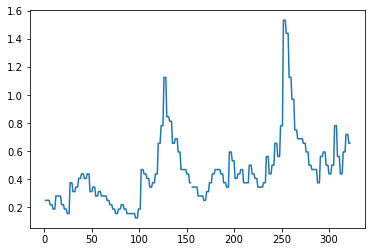

In [122]:
# plotting raw data
plt.plot(data['Hours'],data['Hs [m]'])
plt.show()

In [123]:
import copy
data_raw = copy.deepcopy(data)

### handling outliers

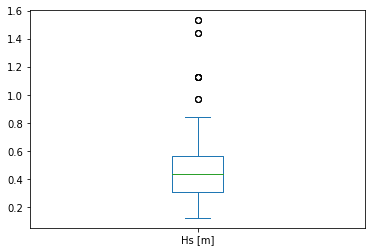

In [124]:
data['Hs [m]'].plot(kind='box', sharex=False, sharey=False)
plt.show()

In [125]:
# calculate q1, q3, iqr 
q1 = data['Hs [m]'].quantile(0.25)
q3 = data['Hs [m]'].quantile(0.75)
iqr = q3 - q1

In [126]:
data['Hs [m]'].loc[(data['Hs [m]']> q3+(1.5*iqr)) & (data['Hs [m]']<= q3+(3*iqr)) ]

125    1.125
126    1.125
127    1.125
257    1.125
258    1.125
259    1.125
260    0.969
261    0.969
262    0.969
Name: Hs [m], dtype: float64

In [127]:
# outlier atas
data['Hs [m]'].loc[(data['Hs [m]']> q3+(1.5*iqr)) & (data['Hs [m]']<= q3+(3*iqr)) ] = np.nan

#outlier bawah
data['Hs [m]'].loc[(data['Hs [m]']< q1-(1.5*iqr)) & (data['Hs [m]']>= q1-(3*iqr)) ] = np.nan

# nilai ekstrim bawah
data['Hs [m]'].loc[data['Hs [m]']> q3 + (3*iqr) ] = np.nan

# nilai ekstrim atas
data['Hs [m]'].loc[data['Hs [m]']< q1 - (3*iqr) ] = np.nan

<ipython-input-127-ec481b66d679>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-127-ec481b66d679>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-127-ec481b66d679>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-127-ec481b66d679>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

In [128]:
data.head()

,Date,Hours,Hs [m],Angin [m/s]
0,1998-10-30 04:00:00,1,0.25,3.278009
1,1998-10-30 05:00:00,2,0.25,2.625278
2,1998-10-30 06:00:00,3,0.25,2.227879
3,1998-10-30 07:00:00,4,0.25,2.528553
4,1998-10-30 08:00:00,5,0.25,2.701536


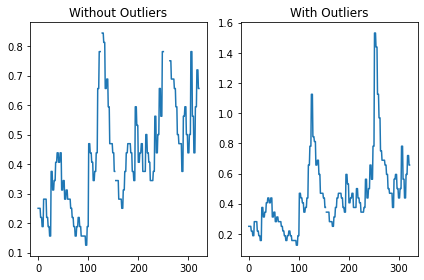

In [129]:
plt.subplot(121)
plt.plot(data['Hs [m]'])
plt.title('Without Outliers')

plt.subplot(122)
plt.plot(data_raw['Hs [m]'])
plt.title('With Outliers')

plt.tight_layout()

### Interpolation

In [130]:
# import library
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

In [131]:
# define other dataframe for interpolate 
data2 = copy.deepcopy(data)
data3 = copy.deepcopy(data)
data4 = copy.deepcopy(data)

In [132]:
# drop NaN value in dataframe data
data = data.dropna()

In [133]:
# cubic interpolation
y_fc=interp1d(data['Hours'],data['Hs [m]'], kind='cubic')

In [134]:
# quadratic interpolation
y_fq=interp1d(data['Hours'],data['Hs [m]'], kind='quadratic')

In [135]:
y_fc=CubicSpline(data['Hours'],data['Hs [m]'],extrapolate=True)

In [136]:
# linear interpolation
y_fl=interp1d(data['Hours'],data['Hs [m]'], kind='linear')

In [137]:
# interpolate using function we define before
import math

for i in data2['Hours'] :
  if math.isnan(data2['Hs [m]'][i-1])== True:
    data2['Hs [m]'][i-1] = y_fc(i)
    data3['Hs [m]'][i-1] = y_fq(i)
    data4['Hs [m]'][i-1] = y_fl(i)
  else:
    pass
#data.loc[data['Hs [m]'].isna()]

<ipython-input-137-86623d2f7eed>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-137-86623d2f7eed>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-137-86623d2f7eed>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



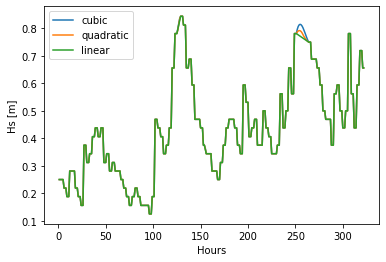

In [138]:
# plot after interpolation
plt.plot(data2['Hours'],data2['Hs [m]'], label ='cubic')
plt.plot(data3['Hours'],data3['Hs [m]'], label ='quadratic')
plt.plot(data4['Hours'],data4['Hs [m]'], label ='linear')
#plotting scatter point of data
plt.xlabel('Hours')
plt.ylabel('Hs [m]')
plt.legend()
plt.show()

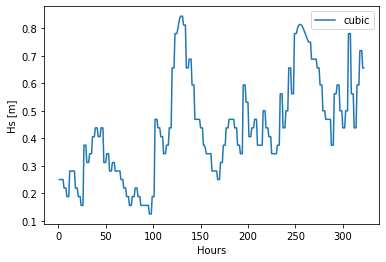

In [139]:
# plot after interpolation
plt.plot(data2['Hours'],data2['Hs [m]'], label ='cubic')
#plotting scatter point of data
plt.xlabel('Hours')
plt.ylabel('Hs [m]')
plt.legend()
plt.show()

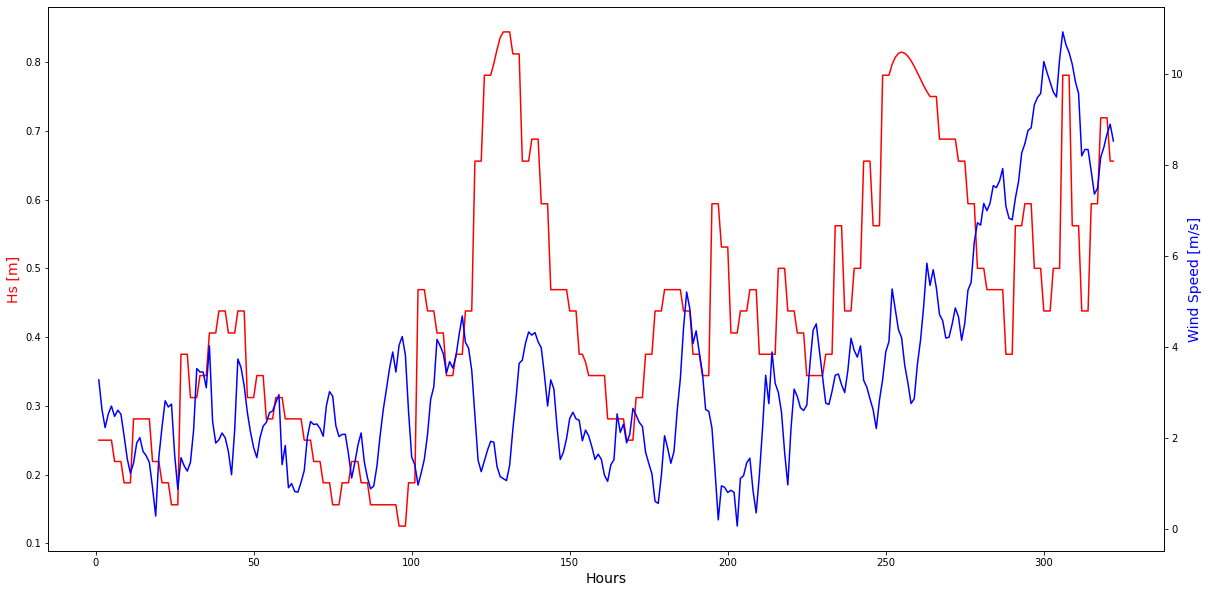

In [140]:
# plotting wind and wave
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(20, 10))
# make a plot
ax.plot(data2['Hours'],
        data2['Hs [m]'],
        color="red", 
        )
# set x-axis label
ax.set_xlabel("Hours", fontsize = 14)
# set y-axis label
ax.set_ylabel("Hs [m]",
              color="red",
              fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data2['Hours'],
        data2['Angin [m/s]'],color="blue")
ax2.set_ylabel("Wind Speed [m/s]",color="blue",fontsize=14)
plt.show()

karena data tidak berdistribusi normal -> ada skew nya (positif) makanya buat scaling data pake -> Normalize Data

### splitting data

In [141]:
data_swh = data2[['Hs [m]','Angin [m/s]']]
type(data_swh), data_swh.shape

(pandas.core.frame.DataFrame, (322, 2))

In [142]:
len(data_swh)

322

In [143]:
data_swh[1:5]

,Hs [m],Angin [m/s]
1,0.25,2.625278
2,0.25,2.227879
3,0.25,2.528553
4,0.25,2.701536


**Pembagian data**

train = data 70% --> 1 - 2556

val = data 10% --> 2557 - 2928

test = data 20% --> 2929 - 3648

In [144]:
train = data_swh[:216]
val = data_swh[216:252]
test = data_swh[252:312]
train.shape, val.shape, test.shape

((216, 2), (36, 2), (60, 2))

In [145]:
# resturvture into windows of 12 hours data
train = array(split(train, round(len(train)/12)))
val = array(split(val, round(len(val)/12)))
test = array(split(test, round(len(test)/12)))
train.shape, val.shape, test.shape

((18, 12, 2), (3, 12, 2), (5, 12, 2))

In [146]:
data_train = train.reshape((train.shape[0]*train.shape[1],train.shape[2] ))
data_val = val.reshape((val.shape[0]*val.shape[1],train.shape[2] ))
data_train.shape, data_val.shape

((216, 2), (36, 2))

In [147]:
len(data_train)

216

In [148]:
def split_into_xy(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [149]:
n_steps_in, n_steps_out = 12, 12
X_train, y_train = split_into_xy(data_train,n_steps_in, n_steps_out)
X_val, y_val = split_into_xy(data_val,n_steps_in, n_steps_out)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((193, 12, 2), (193, 12, 2), (13, 12, 2), (13, 12, 2))

In [150]:
n_features = 2
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_train.shape,X_val.shape

((193, 12, 2), (13, 12, 2))

In [151]:
y_train = y_train[:,:,0].reshape((y_train.shape[0], y_train.shape[1],))
y_val = y_val[:,:,0].reshape((y_val.shape[0], y_val.shape[1],))
y_train.shape,y_val.shape

((193, 12), (13, 12))

## Model

In [152]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# define model
model = Sequential()
model.add(LSTM(96, activation='sigmoid', input_shape=(n_timesteps, n_features)))
model.add(RepeatVector(n_outputs))
model.add(LSTM(36, activation='relu'))
model.add(RepeatVector(n_outputs))
model.add(LSTM(36, activation='relu'))
model.add(RepeatVector(n_outputs))
model.add(LSTM(36, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(24, activation='relu')))
model.add(TimeDistributed(Dense(1)))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 96)                38016     
                                                                 
 repeat_vector_28 (RepeatVec  (None, 12, 96)           0         
 tor)                                                            
                                                                 
 lstm_38 (LSTM)              (None, 36)                19152     
                                                                 
 repeat_vector_29 (RepeatVec  (None, 12, 36)           0         
 tor)                                                            
                                                                 
 lstm_39 (LSTM)              (None, 36)                10512     
                                                                 
 repeat_vector_30 (RepeatVec  (None, 12, 36)          

In [153]:
cp1 = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [154]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[cp1])

Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 0.1554 - root_mean_squared_error: 0.3942

7/7 [==============================] - 19s 2s/step - loss: 0.1554 - root_mean_squared_error: 0.3942 - val_loss: 0.2543 - val_root_mean_squared_error: 0.5043
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 0.1402 - root_mean_squared_error: 0.3744

7/7 [==============================] - 8s 1s/step - loss: 0.1402 - root_mean_squared_error: 0.3744 - val_loss: 0.2303 - val_root_mean_squared_error: 0.4799
Epoch 3/50
6/7 [========================>.....] - ETA: 0s - loss: 0.1229 - root_mean_squared_error: 0.3505

7/7 [==============================] - 9s 1s/step - loss: 0.1229 - root_mean_squared_error: 0.3506 - val_loss: 0.1998 - val_root_mean_squared_error: 0.4469
Epoch 4/50
7/7 [==============================] - ETA: 0s - loss: 0.1022 - root_mean_squared_error: 0.3196

7/7 [==============================] - 8s 1s/step - loss: 0.1022 - root_mean_squared_error: 0.3196 - val_loss: 0.1621 - val_root_mean_squared_error: 0.4026
Epoch 5/50
7/7 [==============================] - ETA: 0s - loss: 0.0786 - root_mean_squared_error: 0.2804

7/7 [==============================] - 9s 2s/step - loss: 0.0786 - root_mean_squared_error: 0.2804 - val_loss: 0.1174 - val_root_mean_squared_error: 0.3426
Epoch 6/50
6/7 [========================>.....] - ETA: 0s - loss: 0.0557 - root_mean_squared_error: 0.2361

7/7 [==============================] - 8s 1s/step - loss: 0.0561 - root_mean_squared_error: 0.2368 - val_loss: 0.0695 - val_root_mean_squared_error: 0.2636
Epoch 7/50
7/7 [==============================] - ETA: 0s - loss: 0.0403 - root_mean_squared_error: 0.2007

7/7 [==============================] - 9s 1s/step - loss: 0.0403 - root_mean_squared_error: 0.2007 - val_loss: 0.0344 - val_root_mean_squared_error: 0.1856
Epoch 8/50
7/7 [==============================] - ETA: 0s - loss: 0.0403 - root_mean_squared_error: 0.2007

7/7 [==============================] - 9s 1s/step - loss: 0.0403 - root_mean_squared_error: 0.2007 - val_loss: 0.0313 - val_root_mean_squared_error: 0.1770
Epoch 9/50
7/7 [==============================] - 0s 38ms/step - loss: 0.0387 - root_mean_squared_error: 0.1968 - val_loss: 0.0414 - val_root_mean_squared_error: 0.2034
Epoch 10/50
7/7 [==============================] - 0s 36ms/step - loss: 0.0375 - root_mean_squared_error: 0.1937 - val_loss: 0.0393 - val_root_mean_squared_error: 0.1982
Epoch 11/50
7/7 [==============================] - 0s 37ms/step - loss: 0.0371 - root_mean_squared_error: 0.1926 - val_loss: 0.0394 - val_root_mean_squared_error: 0.1984
Epoch 12/50
7/7 [==============================] - 0s 41ms/step - loss: 0.0367 - root_mean_squared_error: 0.1915 - val_loss: 0.0444 - val_root_mean_squared_error: 0.2108
Epoch 13/50
7/7 [==============================] - 0s 49ms/step - loss: 0.0365 - root_mean_squared_error: 0.1912 - val_loss: 0.0425 - val_root_mean_squared_error: 0.

7/7 [==============================] - 8s 1s/step - loss: 0.0331 - root_mean_squared_error: 0.1820 - val_loss: 0.0265 - val_root_mean_squared_error: 0.1628
Epoch 23/50
7/7 [==============================] - ETA: 0s - loss: 0.0355 - root_mean_squared_error: 0.1884

7/7 [==============================] - 10s 2s/step - loss: 0.0355 - root_mean_squared_error: 0.1884 - val_loss: 0.0233 - val_root_mean_squared_error: 0.1525
Epoch 24/50
7/7 [==============================] - 0s 38ms/step - loss: 0.0335 - root_mean_squared_error: 0.1831 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1879
Epoch 25/50
7/7 [==============================] - 0s 41ms/step - loss: 0.0328 - root_mean_squared_error: 0.1812 - val_loss: 0.0430 - val_root_mean_squared_error: 0.2075
Epoch 26/50
7/7 [==============================] - 0s 38ms/step - loss: 0.0327 - root_mean_squared_error: 0.1810 - val_loss: 0.0362 - val_root_mean_squared_error: 0.1903
Epoch 27/50
7/7 [==============================] - 0s 40ms/step - loss: 0.0321 - root_mean_squared_error: 0.1792 - val_loss: 0.0301 - val_root_mean_squared_error: 0.1736
Epoch 28/50
7/7 [==============================] - 0s 41ms/step - loss: 0.0321 - root_mean_squared_error: 0.1790 - val_loss: 0.0313 - val_root_mean_squared_error: 

7/7 [==============================] - 8s 1s/step - loss: 0.0310 - root_mean_squared_error: 0.1762 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1454
Epoch 49/50
7/7 [==============================] - 0s 42ms/step - loss: 0.0302 - root_mean_squared_error: 0.1739 - val_loss: 0.0347 - val_root_mean_squared_error: 0.1863
Epoch 50/50
7/7 [==============================] - 0s 38ms/step - loss: 0.0298 - root_mean_squared_error: 0.1727 - val_loss: 0.0474 - val_root_mean_squared_error: 0.2176


In [155]:
from tensorflow.keras.models import load_model
model = load_model('model/')

In [156]:
n_input = 12

In [157]:
history = [x for x in val]
predictions = list()
for i in range(len(test)):
  data = array(history)
  data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  input_x = data[-n_input:,: ]
  input_x = input_x.reshape((1, len(input_x), 2))
  # predict the week
  yhat = model.predict(input_x, verbose=0)
  yhat_sequence = yhat[0]
  # store the predictions
  predictions.append(yhat_sequence)
  # get real observation and add to history for predicting the next week
  history.append(test[i, :])

In [158]:
array(predictions).shape

(5, 12, 1)

In [159]:
prediksi = array(predictions)
observasi = test[:,:,0]
prediksi = prediksi.reshape((prediksi.shape[0]*prediksi.shape[1], 1))
observasi = observasi.reshape((observasi.shape[0]*observasi.shape[1], 1))

In [160]:
import pandas as pd
test_results = pd.DataFrame(data={'Univariate':prediksi.flatten(), 
                                   'Actuals':observasi.flatten()})
test_results

,Univariate,Actuals
0,0.307189,0.807035
1,0.426633,0.812839
2,0.474921,0.814638
3,0.490980,0.813035
4,0.488649,0.808631
5,0.490829,0.802029
6,0.487314,0.793832
7,0.479908,0.784641
8,0.470401,0.775061
9,0.457768,0.765692


In [161]:
test_results['Date'] = data2['Date'].iloc[252:312].values
test_results.head()

,Univariate,Actuals,Date
0,0.307189,0.807035,1998-11-09 16:00:00
1,0.426633,0.812839,1998-11-09 17:00:00
2,0.474921,0.814638,1998-11-09 18:00:00
3,0.490980,0.813035,1998-11-09 19:00:00
4,0.488649,0.808631,1998-11-09 20:00:00


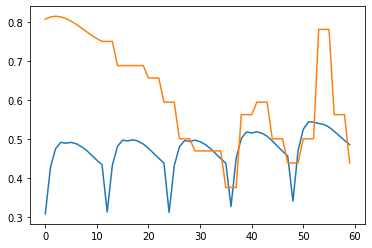

In [162]:
plt.plot(test_results['Univariate'])
plt.plot(test_results['Actuals'])

In [163]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_results['Date'], y=test_results['Univariate'],
                    mode='lines',
                    name='Fitting Data Testing'))
fig.add_trace(go.Scatter(x=test_results['Date'], y=test_results['Actuals'],
                    mode='lines',fillcolor='#ff0000',
                    name='Observation'))

# Edit the layout
fig.update_layout( xaxis_title='<b>Date</b>',
                   yaxis_title='<b><i>Hs</i> [m]</b>')


In [164]:
from sklearn.metrics import mean_squared_error
import math

MSE = mean_squared_error(test_results['Actuals'],test_results['Univariate'])
RMSE = math.sqrt(MSE)
RMSE

0.20035049158285928

In [165]:
from scipy.stats import pearsonr
corr, _ = pearsonr(test_results['Actuals'],test_results['Univariate'])
corr

0.005482751853215342

In [166]:
# bias 
gap_sum = 0
for j in range(len(test_results['Actuals'])):
  gap = test_results['Univariate'][j] - test_results['Actuals'][j]
  gap_sum += gap

bias = gap_sum/len(test_results['Actuals'])
bias

-0.13810417996861438

In [ ]:
# test_results.to_csv('/content/drive/MyDrive/TA (1)/Learn to Code ML/Hasil Prediksi /multi-step/multivariate_12jam_lstm_masalembo.csv')